# Setup Notebook

In [1]:
# When working in AI LRZ
%cd ~/cma/CMA_Fairness_v2

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
%run analysis__setup.ipynb

## Prepare Data


In [ ]:
# Filter out a single configuration to keep data manageable
#df_agg = df_agg_full[
#  (df_agg_full["sett_eval_fairness_grouping"] == "nationality-all") #&
#  #(df_agg_full["sett_eval_exclude_subgroups"] == "keep-in-eval") &
#  #(df_agg_full["sett_eval_on_subset"] == "full")
#][
#  # Remove eval columns
#  cols_non_eval + cols_performance + cols_fairness
#].reset_index(drop = True)
#
#df_agg.shape

In [3]:
import pandas as pd

df_agg = pd.read_csv("./results/cp_metrics/combined_cp_metrics.csv")

In [4]:
df_agg.head()

,universe_id,universe_model,universe_exclude_features,universe_exclude_subgroups,q_hat,coverage,avg_size
0,ff781731dcdee78c262ffadb63156903,penalized_logreg,nationality,keep-all,0.675691,0.911626,1.199955
1,d68204b406b3db0bba5ef9dfec05f208,logreg,nationality,keep-all,0.675691,0.911626,1.199955
2,41371f7240f084e92e79a21cc3dc2e21,logreg,none,drop-non-german,0.667985,0.910946,1.209118
3,f4aa7f1a938cc9245663d6b4d0596022,gbm,none,drop-non-german,0.664399,0.912095,1.117178
4,aeda81ea848062c8b09ab80466cf07c3,logreg,sex,drop-non-german,0.673419,0.911002,1.212451


In [5]:
df_agg.shape

(40, 7)

In [6]:
main_cp_metric = "avg_size"

# Calculate Variable Importance

## Use a Lasso Regression to estimate Importance of Settings

In [11]:
X = df_agg[["universe_model", "universe_exclude_features", "universe_exclude_subgroups"]]
y = df_agg[main_cp_metric]

In [12]:
X.head()

,universe_model,universe_exclude_features,universe_exclude_subgroups
0,penalized_logreg,nationality,keep-all
1,logreg,nationality,keep-all
2,logreg,none,drop-non-german
3,gbm,none,drop-non-german
4,logreg,sex,drop-non-german


In [14]:
X.shape

(40, 3)

In [15]:
y.shape

(40,)

### Main Effects of Settings Only (i.e. no interations)

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV

# Do preprocessing in a separate pipeline from model fitting
# (for eli5 to work)
preprocessor = make_pipeline(
    OneHotEncoder(), # Converts categorical features to one-hot encoded format
).fit(X) # Fit the preprocessing pipeline to the input data X
X_processed = preprocessor.transform(X) # This creates a numeric matrix suitable for modeling

# Fit a Lasso regression model with cross-validation to the processed data
lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.9873855070684405

R² = 1.0: Perfect predictions

R² = 0.0: Model does no better than predicting the mean

R² < 0.0: Model is worse than just predicting the mean

Weights of importance:

In [18]:
# Visualize the importance of each feature in trained lasso_reg model
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+1.143,<BIAS>
+0.061,universe_model_penalized_logreg
+0.061,universe_model_logreg
+0.003,universe_exclude_subgroups_drop-non-german
-0.000,universe_exclude_subgroups_keep-all
-0.002,universe_exclude_features_nationality-sex
-0.010,universe_model_elasticnet
-0.026,universe_model_gbm


### Including Interactions

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LassoCV

# Do preprocessing w/o a pipeline for eli5 to work
preprocessor = make_pipeline(
    OneHotEncoder(),
    PolynomialFeatures(degree=2),
).fit(X)
X_processed = preprocessor.transform(X)

lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.9975702351524245

Weights of importance:

In [20]:
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+1.148,<BIAS>
+0.044,universe_model_penalized_logreg
+0.042,universe_model_logreg
+0.011,universe_model_logreg^2
+0.010,universe_model_penalized_logreg universe_exclude_subgroups_drop-non-german
+0.010,universe_model_logreg universe_exclude_subgroups_drop-non-german
+0.009,universe_model_penalized_logreg^2
+0.001,universe_exclude_features_none universe_exclude_subgroups_keep-all
+0.000,universe_model_penalized_logreg universe_exclude_features_sex
+0.000,universe_model_logreg universe_exclude_features_sex


## Use a functinoal ANOVA (fANOVA) to Analyze Setting Importance

Based on the following paper:

Hutter, F., Hoos, H., & Leyton-Brown, K. (2014). An Efficient Approach for Assessing Hyperparameter Importance. Proceedings of the 31st International Conference on Machine Learning, 754–762. https://proceedings.mlr.press/v32/hutter14.html


In [21]:
from fairness_multiverse.analysis import MultiverseFanova

m_fanova = MultiverseFanova(features = df_agg[["universe_model", "universe_exclude_features", "universe_exclude_subgroups"]], outcome = df_agg[main_cp_metric])


In [ ]:
# delete later
df_agg_cols_non_eval = df_agg[cols_non_eval].copy()
df_agg_main_fairness_metric = df_agg[main_fairness_metric].copy()

In [ ]:
# delete later
import fanova
print(fanova.__file__)

In [22]:
m_fanova.quantify_individual_importance()

,individual importance,total importance,individual std,total std
universe_exclude_features,0.021553,0.021553,0.046550,0.046550
universe_exclude_subgroups,0.004539,0.004539,0.006824,0.006824
universe_model,0.876573,0.876573,0.153904,0.153904


In [24]:
m_fanova.quantify_importance(save_to = "fanova_importance_interactions-overall.csv")

,level_0,level_1,level_2,individual importance,total importance,individual std,total std
2,universe_model,NaN,NaN,0.876573,0.876573,0.153904,1.539043e-01
4,universe_exclude_features,universe_model,NaN,0.072647,0.970773,0.100753,3.160408e-02
0,universe_exclude_features,NaN,NaN,0.021553,0.021553,0.046550,4.655001e-02
5,universe_exclude_subgroups,universe_model,NaN,0.009461,0.890573,0.006392,1.501490e-01
3,universe_exclude_features,universe_exclude_subgroups,NaN,0.008723,0.034816,0.018068,6.078956e-02
6,universe_exclude_features,universe_exclude_subgroups,universe_model,0.006504,1.000000,0.013207,4.732549e-15
1,universe_exclude_subgroups,NaN,NaN,0.004539,0.004539,0.006824,6.824287e-03


In [25]:
best_p_margs = m_fanova.fanova.get_most_important_pairwise_marginals(n=5)
print(best_p_margs)

OrderedDict([(('universe_exclude_features', 'universe_model'), 0.0726473051204004), (('universe_exclude_subgroups', 'universe_model'), 0.009460675106850627), (('universe_exclude_features', 'universe_exclude_subgroups'), 0.008723394355438287)])


In [34]:
# Directory that will contain outputs from analysis

from pathlib import Path

ANALYSIS_OUTPUT_DIR = Path(".") / "analyses"
ANALYSIS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [35]:
from fanova import visualizer

vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(ANALYSIS_OUTPUT_DIR))

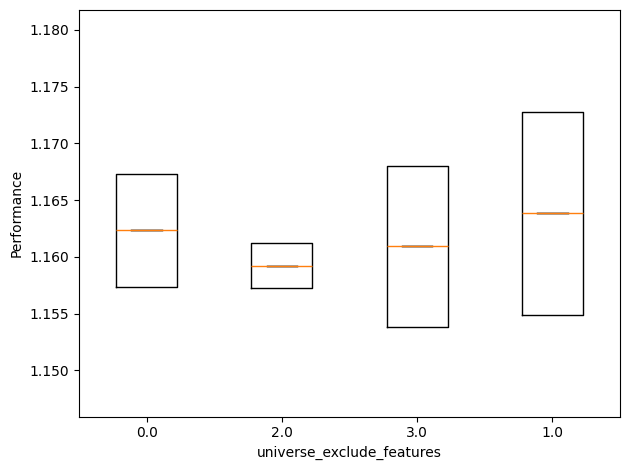

In [30]:
vis.plot_marginal(0)

/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)
INFO:fanova.visualizer.Visualizer:creating results/interactive_plots


<module 'matplotlib.pyplot' from '/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/matplotlib/pyplot.py'>

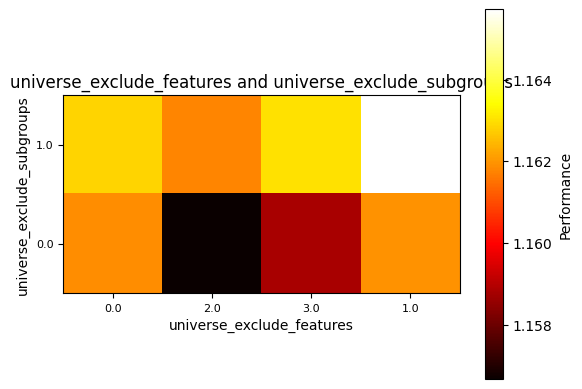

In [32]:
vis.plot_pairwise_marginal(['universe_exclude_features', 'universe_exclude_subgroups'])

## Quantify Importance with Partial Data

In [36]:
from tqdm import tqdm

PARTIAL_FANOVA_DIR = ANALYSIS_OUTPUT_DIR / "partial_fanova" / "overall"
PARTIAL_FANOVA_DIR.mkdir(parents=True, exist_ok=True)

N_ITERATIONS = 10

In [41]:
from fairness_multiverse.analysis import MultiverseFanova
import joblib

def quantify_importance_for_fraction(fraction: float, base_directory = PARTIAL_FANOVA_DIR):
    # Get random subset of the data
    df = df_agg.sample(frac = fraction).reset_index(drop = True)
    data_hash = joblib.hash(df)

    # Create directory for this fraction
    directory = base_directory / f"fraction-{fraction}"
    directory.mkdir(exist_ok = True)

    # Run FANOVA on subset
    partial_fanova = MultiverseFanova(features = df[["universe_model", "universe_exclude_features", "universe_exclude_subgroups"]], outcome = df[main_cp_metric])
    partial_fanova.quantify_importance(save_to = directory / f"partial-fanova_importance_interactions-majmin-{fraction}-{data_hash}.csv")

In [42]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.01)

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.05)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.1)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.2)